In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer

In [3]:
import datetime

In [4]:
pbp_df = PlayByPlayV2(game_id="0022000628").get_data_frames()[0]

In [142]:
pbp_df.SCORE

0           None
1           None
2          2 - 0
3           None
4           None
         ...    
485         None
486         None
487         None
488         None
489    123 - 119
Name: SCORE, Length: 490, dtype: object

In [129]:
pbp_df.iloc[-30]

GAME_ID                                                  0022000628
EVENTNUM                                                        659
EVENTMSGTYPE                                                      9
EVENTMSGACTIONTYPE                                                1
PERIOD                                                            4
WCTIMESTRING                                               12:16 AM
PCTIMESTRING                                                   0:38
HOMEDESCRIPTION              SUNS Timeout: Regular (Full 6 Short 0)
NEUTRALDESCRIPTION                                             None
VISITORDESCRIPTION                                             None
SCORE                                                          None
SCOREMARGIN                                                    None
PERSON1TYPE                                                       2
PLAYER1_ID                                               1610612756
PLAYER1_NAME                                    

In [ ]:
def map_to_time(row):
    space_split = row.split(" ")
    am_pm = space_split[1]
    _time = space_split[0]
    hours = 

In [19]:
pbp_df.WCTIMESTRING.map(lambda item: int(item.split(":")[0]) * 60 + )

0      10:11 PM
1      10:11 PM
2      10:11 PM
3      10:11 PM
4      10:11 PM
         ...   
485    12:27 AM
486    12:27 AM
487    12:27 AM
488    12:27 AM
489    12:27 AM
Name: WCTIMESTRING, Length: 490, dtype: object

In [21]:
start = pbp_df.WCTIMESTRING.iloc[0]

In [22]:
end = pbp_df.WCTIMESTRING.iloc[-1]

In [24]:
start

'10:11 PM'

In [25]:
end

'12:27 AM'

In [38]:
datetime.strptime(start, '%I:%M %p')

datetime.datetime(1900, 1, 1, 22, 11)

In [39]:
datetime.strptime(end, '%I:%M %p')

datetime.datetime(1900, 1, 1, 0, 27)

In [40]:
game_finder = LeagueGameFinder(season_nullable='2020-21', league_id_nullable='00', season_type_nullable='Regular Season')
df = game_finder.get_data_frames()[0]

## Game lengths

### Load data

In [5]:
full_df = pd.read_csv('pbp_analysis/pbp_data/2020-21.csv')

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:

full_df = full_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
full_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in full_df.GAME_ID.astype(str)]
#full_df.loc[:, "PCTIMESECONDS"] = [720 - (int(item.split(":")[0]) * 60 + int(item.split(":")[1])) for item in full_df.PCTIMESTRING.tolist()]
full_df.loc[:, "PCTIMESECONDS"] = [720 - (int(item.PCTIMESTRING.split(":")[0]) * 60 + int(item.PCTIMESTRING.split(":")[1])) if item.PERIOD < 5 else 300 - (int(item.PCTIMESTRING.split(":")[0]) * 60 + int(item.PCTIMESTRING.split(":")[1])) for index, item in full_df.iterrows()]

In [7]:
game_finder = LeagueGameFinder(season_nullable='2020-21', league_id_nullable='00', season_type_nullable='Regular Season')
df = game_finder.get_data_frames()[0]

In [8]:
full_df.head()

,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESECONDS,PCTIMESTRING,PERIOD,PERSON1TYPE,...,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VIDEO_AVAILABLE_FLAG,VISITORDESCRIPTION,WCTIMESTRING
0,0,12,2,0022000267,,,0,12:00,1,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,,10:11 PM
1,0,10,4,0022000267,Jump Ball Kanter vs. Roby: Tip to Gilgeous-Ale...,,0,12:00,1,4.0,...,Shai Gilgeous-Alexander,OKC,Oklahoma City,1.610613e+09,Thunder,NaN,NaN,1,,10:11 PM
2,1,2,7,0022000267,,,17,11:43,1,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,MISS Dort 25' 3PT Jump Shot,10:11 PM
3,0,4,8,0022000267,Anthony REBOUND (Off:0 Def:1),,19,11:41,1,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,,10:11 PM
4,1,2,9,0022000267,MISS Anthony 26' 3PT Jump Shot,,28,11:32,1,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,,10:11 PM


### Loop

In [9]:
# Test

target = '2021-03-31'
splitted = target.split('-')
date = datetime.datetime(year=int(splitted[0]), month=int(splitted[1]), day=int(splitted[2]))
new_date = date + datetime.timedelta(days=1)

new_date.day

a = (new_date - date)

new_date

game_pbp.iloc[0].WCTIMESTRING

start_pm = 'PM' in game_pbp.iloc[0].WCTIMESTRING

get_date(game_pbp.iloc[0], item.GAME_DATE, start_pm)

NameError: name 'game_pbp' is not defined

In [10]:
def get_date(row, date, start_pm):
    splitted = target.split('-')
    calendar_date = datetime.datetime(year=int(splitted[0]), month=int(splitted[1]), day=int(splitted[2]))
    
    time_str = row
    am_pm = time_str.split(" ")[1]
    time_split = time_str.split(" ")[0].split(":")
    hours = time_split[0]
    minutes = time_split[1]
    
    target_date = calendar_date
    if am_pm == 'AM' and start_pm:
        target_date = calendar_date + datetime.timedelta(days=1)
    
    str_time = f"{target_date.strftime('%Y-%m-%d')} {hours}:{minutes} {am_pm}"
    return datetime.datetime.strptime(str_time, "%Y-%m-%d %I:%M %p")

In [17]:
df = df.loc[(df.GAME_DATE != '2021-03-21') & (df.GAME_DATE != '2021-03-20')]

In [18]:
df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
18,22020,1610612756,PHX,Phoenix Suns,0022000638,2021-03-19,PHX vs. MIN,W,243,113,...,0.765,6,34,40,29,8,1,18,19,12.0
19,22020,1610612753,ORL,Orlando Magic,0022000633,2021-03-19,ORL vs. BKN,W,238,121,...,0.700,8,36,44,26,4,1,17,20,8.0
20,22020,1610612745,HOU,Houston Rockets,0022000635,2021-03-19,HOU vs. DET,L,240,100,...,0.813,7,31,38,21,7,4,13,17,-13.0
21,22020,1610612757,POR,Portland Trail Blazers,0022000639,2021-03-19,POR vs. DAL,W,239,125,...,0.882,13,30,43,17,5,0,6,15,6.0
22,22020,1610612739,CLE,Cleveland Cavaliers,0022000435,2021-03-19,CLE vs. SAS,L,241,110,...,0.781,15,32,47,19,8,4,10,21,-6.0
23,22020,1610612744,GSW,Golden State Warriors,0022000636,2021-03-19,GSW @ MEM,W,241,116,...,0.722,8,35,43,31,13,6,13,16,13.0
24,22020,1610612759,SAS,San Antonio Spurs,0022000435,2021-03-19,SAS @ CLE,W,241,116,...,0.818,17,34,51,19,5,4,13,25,6.0
25,22020,1610612761,TOR,Toronto Raptors,0022000634,2021-03-19,TOR vs. UTA,L,240,112,...,0.786,3,28,31,31,9,4,10,28,-3.0
26,22020,1610612762,UTA,Utah Jazz,0022000634,2021-03-19,UTA @ TOR,W,240,115,...,0.854,9,39,48,21,7,5,13,16,3.0
27,22020,1610612763,MEM,Memphis Grizzlies,0022000636,2021-03-19,MEM vs. GSW,L,240,103,...,0.810,9,37,46,24,10,6,20,17,-13.0


In [19]:
formatted_dfs = []

for index in tqdm.tqdm(range(len(df))):
    item = df.iloc[index]
    game_pbp = full_df.loc[full_df.GAME_ID == item.GAME_ID]
    start_pm = 'PM' in game_pbp.iloc[0].WCTIMESTRING
    date = item.GAME_DATE
    date_times = game_pbp.WCTIMESTRING.map(lambda row: get_date(row=row, date=date, start_pm=start_pm))
    game_pbp.loc[:, 'DATE_TIME'] = date_times
    scores = []
    margins = []
    prev_score = None
    prev_margin = None
    for index in range(len(game_pbp)):
        item = game_pbp.iloc[index]
        if prev_score is None:
            prev_score = '0 - 0'
            prev_margin = 0
        elif item.SCOREMARGIN is not None and not isinstance(item.SCOREMARGIN, float):
            prev_score = item.SCORE
            prev_margin = 0 if item.SCOREMARGIN == 'TIE' else int(item.SCOREMARGIN)
        
        scores.append(prev_score)
        margins.append(prev_margin)
    game_pbp.loc[:, 'ADJ_SCORE'] = scores
    game_pbp.loc[:, 'ADJ_MARGIN'] = margins
    formatted_dfs.append(game_pbp)

  0%|                                                                                                                                                                                      | 0/1222 [00:00<?, ?it/s]c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [20]:
formatted_full = pd.concat(formatted_dfs)

In [21]:
game_lenghts = []
for game_id in formatted_full.GAME_ID.unique():
    target_game = formatted_full.loc[formatted_full.GAME_ID == game_id]
    start = target_game.iloc[0].DATE_TIME
    end = target_game.iloc[-1].DATE_TIME
    game_lenghts.append((end-start).total_seconds())

KeyboardInterrupt: 

## TODO

* fill the score for each play (simple for loop with remembering previous result)

* Fill the score margins (also simple for loop)

* Fetch all the clutch games (score <3 or less than 5 with 1 minute or less) and check duration of that last minute

In [23]:
clutch_games = formatted_full.loc[(formatted_full.PERIOD >= 4) & (formatted_full.ADJ_MARGIN.abs() <= 5) & (formatted_full.PCTIMESECONDS >= 660)]

In [215]:
clutch_lengths = []
clutch_ids = clutch_games.GAME_ID.unique()
target_time = 660
for game_id in clutch_ids:
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    first = target_df.loc[(target_df.PERIOD == 4) & (target_df.PCTIMESECONDS >= target_time)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == 4) & (target_df.PCTIMESECONDS >= target_time)].iloc[-1]
    diff = (last.DATE_TIME - first.DATE_TIME)
    clutch_lengths.append(diff.total_seconds() / 60)
    
all_ids = formatted_full.GAME_ID.unique()
non_clutch_lengths = []
for game_id in all_ids:
    if game_id in clutch_ids:
        continue
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    first = target_df.loc[(target_df.PERIOD == 4) & (target_df.PCTIMESECONDS >= target_time)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == 4) & (target_df.PCTIMESECONDS >= target_time)].iloc[-1]
    diff = (last.DATE_TIME - first.DATE_TIME)
    non_clutch_lengths.append(diff.total_seconds() / 60)

## Length of last 1 minute

In [216]:
np.mean(clutch_lengths)

8.246963562753036

In [217]:
np.mean(non_clutch_lengths)

2.7225274725274726

## Length of last 3 minutes

In [204]:
clutch_lengths = []
clutch_ids = clutch_games.GAME_ID.unique()
target_time = 540
for game_id in clutch_ids:
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    first = target_df.loc[(target_df.PERIOD == 4) & (target_df.PCTIMESECONDS >= target_time)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == 4) & (target_df.PCTIMESECONDS >= target_time)].iloc[-1]
    diff = (last.DATE_TIME - first.DATE_TIME)
    clutch_lengths.append(diff.total_seconds() / 60)
    
all_ids = formatted_full.GAME_ID.unique()
non_clutch_lengths = []
for game_id in all_ids:
    if game_id in clutch_ids:
        continue
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    first = target_df.loc[(target_df.PERIOD == 4) & (target_df.PCTIMESECONDS >= target_time)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == 4) & (target_df.PCTIMESECONDS >= target_time)].iloc[-1]
    diff = (last.DATE_TIME - first.DATE_TIME)
    non_clutch_lengths.append(diff.total_seconds() / 60)

In [205]:
np.mean(clutch_lengths)

13.356275303643725

In [206]:
np.mean(non_clutch_lengths)

7.277472527472527

## Length of last 5 minutes

In [211]:
clutch_lengths = []
clutch_ids = clutch_games.GAME_ID.unique()
target_time = 420
for game_id in clutch_ids:
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    first = target_df.loc[(target_df.PERIOD == 4) & (target_df.PCTIMESECONDS >= target_time)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == 4) & (target_df.PCTIMESECONDS >= target_time)].iloc[-1]
    diff = (last.DATE_TIME - first.DATE_TIME)
    clutch_lengths.append(diff.total_seconds() / 60)
    
all_ids = formatted_full.GAME_ID.unique()
non_clutch_lengths = []
for game_id in all_ids:
    if game_id in clutch_ids:
        continue
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    first = target_df.loc[(target_df.PERIOD == 4) & (target_df.PCTIMESECONDS >= target_time)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == 4) & (target_df.PCTIMESECONDS >= target_time)].iloc[-1]
    diff = (last.DATE_TIME - first.DATE_TIME)
    non_clutch_lengths.append(diff.total_seconds() / 60)

In [213]:
np.mean(clutch_lengths)

19.16599190283401

In [214]:
np.mean(non_clutch_lengths)

12.54945054945055

## Length of last quarter

In [ ]:
clutch_lengths = []
clutch_ids = clutch_games.GAME_ID.unique()
for game_id in clutch_ids:
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    first = target_df.loc[(target_df.PERIOD == 4)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == 4)].iloc[-1]
    diff = (last.DATE_TIME - first.DATE_TIME)
    clutch_lengths.append(diff.total_seconds() / 60)
    
all_ids = formatted_full.GAME_ID.unique()
non_clutch_lengths = []
for game_id in all_ids:
    if game_id in clutch_ids:
        continue
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    first = target_df.loc[(target_df.PERIOD == 4)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == 4)].iloc[-1]
    diff = (last.DATE_TIME - first.DATE_TIME)
    non_clutch_lengths.append(diff.total_seconds() / 60)

In [201]:
np.mean(clutch_lengths)

35.878542510121456

In [202]:
np.mean(non_clutch_lengths)

29.64010989010989

## Length of 1st quarter

In [24]:
clutch_lengths = []
clutch_ids = clutch_games.GAME_ID.unique()
period = 1
for game_id in clutch_ids:
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    first = target_df.loc[(target_df.PERIOD == period)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == period)].iloc[-1]
    diff = (last.DATE_TIME - first.DATE_TIME)
    clutch_lengths.append(diff.total_seconds() / 60)
    
all_ids = formatted_full.GAME_ID.unique()
non_clutch_lengths = []
for game_id in all_ids:
    if game_id in clutch_ids:
        continue
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    first = target_df.loc[(target_df.PERIOD == period)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == period)].iloc[-1]
    diff = (last.DATE_TIME - first.DATE_TIME)
    non_clutch_lengths.append(diff.total_seconds() / 60)

In [25]:
np.mean(clutch_lengths)

25.09311740890688

In [26]:
np.mean(non_clutch_lengths)

25.384615384615383

### 2nd quarter

In [28]:
clutch_lengths = []
clutch_ids = clutch_games.GAME_ID.unique()
period = 2
for game_id in clutch_ids:
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    first = target_df.loc[(target_df.PERIOD == period)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == period)].iloc[-1]
    diff = (last.DATE_TIME - first.DATE_TIME)
    clutch_lengths.append(diff.total_seconds() / 60)
    
all_ids = formatted_full.GAME_ID.unique()
non_clutch_lengths = []
for game_id in all_ids:
    if game_id in clutch_ids:
        continue
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    first = target_df.loc[(target_df.PERIOD == period)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == period)].iloc[-1]
    diff = (last.DATE_TIME - first.DATE_TIME)
    non_clutch_lengths.append(diff.total_seconds() / 60)

In [29]:
np.mean(clutch_lengths)

27.497975708502025

In [30]:
np.mean(non_clutch_lengths)

27.684065934065934

## 3rd quarter

In [31]:
clutch_lengths = []
clutch_ids = clutch_games.GAME_ID.unique()
period = 3
for game_id in clutch_ids:
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    first = target_df.loc[(target_df.PERIOD == period)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == period)].iloc[-1]
    diff = (last.DATE_TIME - first.DATE_TIME)
    clutch_lengths.append(diff.total_seconds() / 60)
    
all_ids = formatted_full.GAME_ID.unique()
non_clutch_lengths = []
for game_id in all_ids:
    if game_id in clutch_ids:
        continue
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    first = target_df.loc[(target_df.PERIOD == period)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == period)].iloc[-1]
    diff = (last.DATE_TIME - first.DATE_TIME)
    non_clutch_lengths.append(diff.total_seconds() / 60)

In [32]:
np.mean(clutch_lengths)

27.291497975708502

In [33]:
np.mean(non_clutch_lengths)

27.392857142857142

## All seasons

In [14]:
for game_id in full_df.GAME_ID.unique().tolist():
    game_df = full_df.loc[full_df.GAME_ID == game_id]
    #print(game_id)
    
        #print(f"\tStart: {game_df.iloc[0].WCTIMESTRING}")
        #print(f"\tEnd: {game_df.iloc[-1].WCTIMESTRING}")

False

In [11]:
def get_date(row, date, start_pm, season):
    splitted = date.split('-')
    calendar_date = datetime.datetime(year=int(splitted[0]), month=int(splitted[1]), day=int(splitted[2]))
    
    time_str = row
    am_pm = time_str.split(" ")[1]
    time_split = time_str.split(" ")[0].split(":")
    hours = time_split[0]
    minutes = time_split[1]
    
    target_date = calendar_date
    if am_pm == 'AM' and start_pm:
        target_date = calendar_date + datetime.timedelta(days=1)
    #hours = str(int(hours) - 24) if int(hours) >= 24 else hours
    """if int(season.split("-")[0]) < 2012:
        str_time = f"{target_date.strftime('%Y-%m-%d')} {hours}:{minutes}"
        return datetime.datetime.strptime(str_time, "%Y-%m-%d %H:%M")
    """
    str_time = f"{target_date.strftime('%Y-%m-%d')} {hours}:{minutes} {am_pm}"
    return datetime.datetime.strptime(str_time, "%Y-%m-%d %I:%M %p")

In [36]:
seasons = [f"{item}-{str(item+1)[-2:]}" for item in range(2000, 2021)]


In [12]:
time_pbps = []
#seasons = [f"{item}-{str(item+1)[-2:]}" for item in range(, 2015)]


for season in ['2020-21']:
    full_df = pd.read_csv(f'pbp_analysis/pbp_data/{season}.csv')
    
    full_df = full_df.fillna({
        "HOMEDESCRIPTION": "",
        "NEUTRALDESCRIPTION": "",
        "VISITORDESCRIPTION": ""
    })
    full_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in full_df.GAME_ID.astype(str)]
    #full_df.loc[:, "PCTIMESECONDS"] = [720 - (int(item.split(":")[0]) * 60 + int(item.split(":")[1])) for item in full_df.PCTIMESTRING.tolist()]
    #full_df.loc[:, "PCTIMESECONDS"] = [720 - (int(item.PCTIMESTRING.split(":")[0]) * 60 + int(item.PCTIMESTRING.split(":")[1])) if item.PERIOD < 5 else 300 - (int(item.PCTIMESTRING.split(":")[0]) * 60 + int(item.PCTIMESTRING.split(":")[1])) for index, item in full_df.iterrows()]
    game_finder = LeagueGameFinder(season_nullable=season, league_id_nullable='00', season_type_nullable='Regular Season')
    df = game_finder.get_data_frames()[0]
    game_ids = full_df.GAME_ID.unique()
    formatted_dfs = []
    print(f"Starting {season}")
    for index in range(len(df)):
        item = df.iloc[index]
        if item.GAME_ID == '0022000703':
            continue
        game_pbp = full_df.loc[full_df.GAME_ID == item.GAME_ID]
        start_pm = 'PM' in game_pbp.iloc[0].WCTIMESTRING
        start_hour = int(game_pbp.iloc[0].WCTIMESTRING.split(":")[0])
        end_hour = int(game_pbp.iloc[-1].WCTIMESTRING.split(":")[0])
        start_am_pm = game_pbp.iloc[0].WCTIMESTRING.split(" ")[-1]
        end_am_pm = game_pbp.iloc[-1].WCTIMESTRING.split(" ")[-1]
        if (start_hour > 12 and start_am_pm == 'PM') or (end_hour > 12 and end_am_pm == 'PM'):
            continue
        date = item.GAME_DATE
        date_times = game_pbp.WCTIMESTRING.map(lambda row: get_date(row=row, date=date, start_pm=start_pm, season=season))
        game_pbp.loc[:, 'DATE_TIME'] = date_times
        scores = []
        margins = []
        prev_score = None
        prev_margin = None
        for index in range(len(game_pbp)):
            item = game_pbp.iloc[index]
            if prev_score is None:
                prev_score = '0 - 0'
                prev_margin = 0
            elif item.SCOREMARGIN is not None and not isinstance(item.SCOREMARGIN, float):
                prev_score = item.SCORE
                prev_margin = 0 if item.SCOREMARGIN == 'TIE' else int(item.SCOREMARGIN)

            scores.append(prev_score)
            margins.append(prev_margin)
        game_pbp.loc[:, 'ADJ_SCORE'] = scores
        game_pbp.loc[:, 'ADJ_MARGIN'] = margins
        formatted_dfs.append(game_pbp)
    formatted_full = pd.concat(formatted_dfs)
    formatted_full.to_csv(f'pbp_analysis/time_formatted/{season}.csv')

Starting 2020-21


c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Get length of quarter

In [18]:
def get_length_target_time(formatted_df, game_ids, period=4, target_time=660):

    clutch_lengths = []
    target_time = 660
    for game_id in game_ids:
        if game_id == '0021700211':
            continue
        target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
        target_df = target_df.loc[target_df.EVENTMSGTYPE != 13]
        target_df = target_df.loc[(target_df.PERIOD == period) & (target_df.PCTIMESECONDS >= target_time)]
        if len(target_df) == 0:
            print(game_id)
            continue
        first = target_df.iloc[0]
        last = target_df.iloc[-1]
        diff = (last.DATE_TIME - first.DATE_TIME)
        if diff.total_seconds() < 0:
            continue
        clutch_lengths.append(diff.total_seconds() / 60)
    return clutch_lengths

In [14]:
import os

In [15]:
seasons = [f"{item}-{str(item+1)[-2:]}" for item in range(2000, 2021)]

In [19]:
files = os.listdir('pbp_analysis/time_formatted_copy')
clutch_durations = []
non_clutch_durations = []
for season in seasons:
    start = time.time()
    if f"{season}.csv" in files:
        formatted_full = pd.read_csv(f'pbp_analysis/time_formatted_copy/{season}.csv')
    else:
        formatted_full = pd.read_csv(f'pbp_analysis/time_formatted/{season}.csv')

        formatted_full = formatted_full.fillna({
            "HOMEDESCRIPTION": "",
            "NEUTRALDESCRIPTION": "",
            "VISITORDESCRIPTION": ""
        })
        formatted_full.loc[:, "PCTIMESECONDS"] = [720 - (int(item.PCTIMESTRING.split(":")[0]) * 60 + int(item.PCTIMESTRING.split(":")[1])) if item.PERIOD < 5 else 300 - (int(item.PCTIMESTRING.split(":")[0]) * 60 + int(item.PCTIMESTRING.split(":")[1])) for index, item in formatted_full.iterrows()]
    formatted_full.loc[:, 'GAME_ID'] = [f"00{item}" for item in formatted_full.GAME_ID.astype(str)]
    #full_df.loc[:, "PCTIMESECONDS"] = [720 - (int(item.split(":")[0]) * 60 + int(item.split(":")[1])) for item in full_df.PCTIMESTRING.tolist()]
    formatted_full.DATE_TIME = formatted_full.DATE_TIME.astype('datetime64')
    if f"{season}.csv" not in files:
        formatted_full.to_csv(f'pbp_analysis/time_formatted_copy/{season}.csv')
    clutch_games = formatted_full.loc[(formatted_full.PERIOD >= 4) & (formatted_full.ADJ_MARGIN.abs() <= 5) & (formatted_full.PCTIMESECONDS >= 660)]
    clutch_ids = clutch_games.GAME_ID.unique()
    other_ids = formatted_full.loc[~formatted_full.GAME_ID.isin(clutch_ids)].GAME_ID.unique()
    clutch_lengths = get_length_target_time(formatted_full, clutch_ids)
    other_lengths = get_length_target_time(formatted_full, other_ids)
    avg_clutch = np.mean(clutch_lengths)
    avg_other = np.mean(other_lengths)
    #other_min = int(avg_other.split('.')[0])
    #clutch_min = int(avg_clutch.split('.')[0])
    #clutch_seconds = (float(avg_clutch) - clutch_min) * 60
    #other_seconds = (float(avg_other) - other_min) * 60
    end = time.time()
    print(f"Season: {season}; Average duration of last minute in clutch games: {avg_clutch}")
    print(f"Season: {season}; Average duration of last minute in non-clutch games: {avg_other}")
    print(f"Total time: {end-start}, season: {season}")
    clutch_durations.append(avg_clutch)
    non_clutch_durations.append(avg_other)

Season: 2000-01; Average duration of last minute in clutch games: 7.417153996101365
Season: 2000-01; Average duration of last minute in non-clutch games: 2.3593984962406016
Total time: 77.81051325798035, season: 2000-01
Season: 2001-02; Average duration of last minute in clutch games: 7.550537634408602
Season: 2001-02; Average duration of last minute in non-clutch games: 2.2113821138211383
Total time: 64.80393266677856, season: 2001-02
Season: 2002-03; Average duration of last minute in clutch games: 7.517906336088155
Season: 2002-03; Average duration of last minute in non-clutch games: 2.32064128256513
Total time: 43.83529782295227, season: 2002-03
Season: 2003-04; Average duration of last minute in clutch games: 8.087606837606838
Season: 2003-04; Average duration of last minute in non-clutch games: 2.3026315789473686
Total time: 65.72169041633606, season: 2003-04
Season: 2004-05; Average duration of last minute in clutch games: 8.12742980561555
Season: 2004-05; Average duration of la

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Season: 2020-21; Average duration of last minute in clutch games: 7.906474820143885
Season: 2020-21; Average duration of last minute in non-clutch games: 2.1893203883495147
Total time: 105.967276096344, season: 2020-21


In [20]:
json_data = {
    "clutch": clutch_durations,
    "non_clutch": non_clutch_durations
}

In [22]:
import json

In [23]:
with open('pbp_analysis/time_formatted/summary.json', 'w') as f:
    json.dump(json_data, f, indent=4)

## Chart through years

In [25]:
plt.style.use('fivethirtyeight')

Text(0, -0.5, 'source: nba.com')

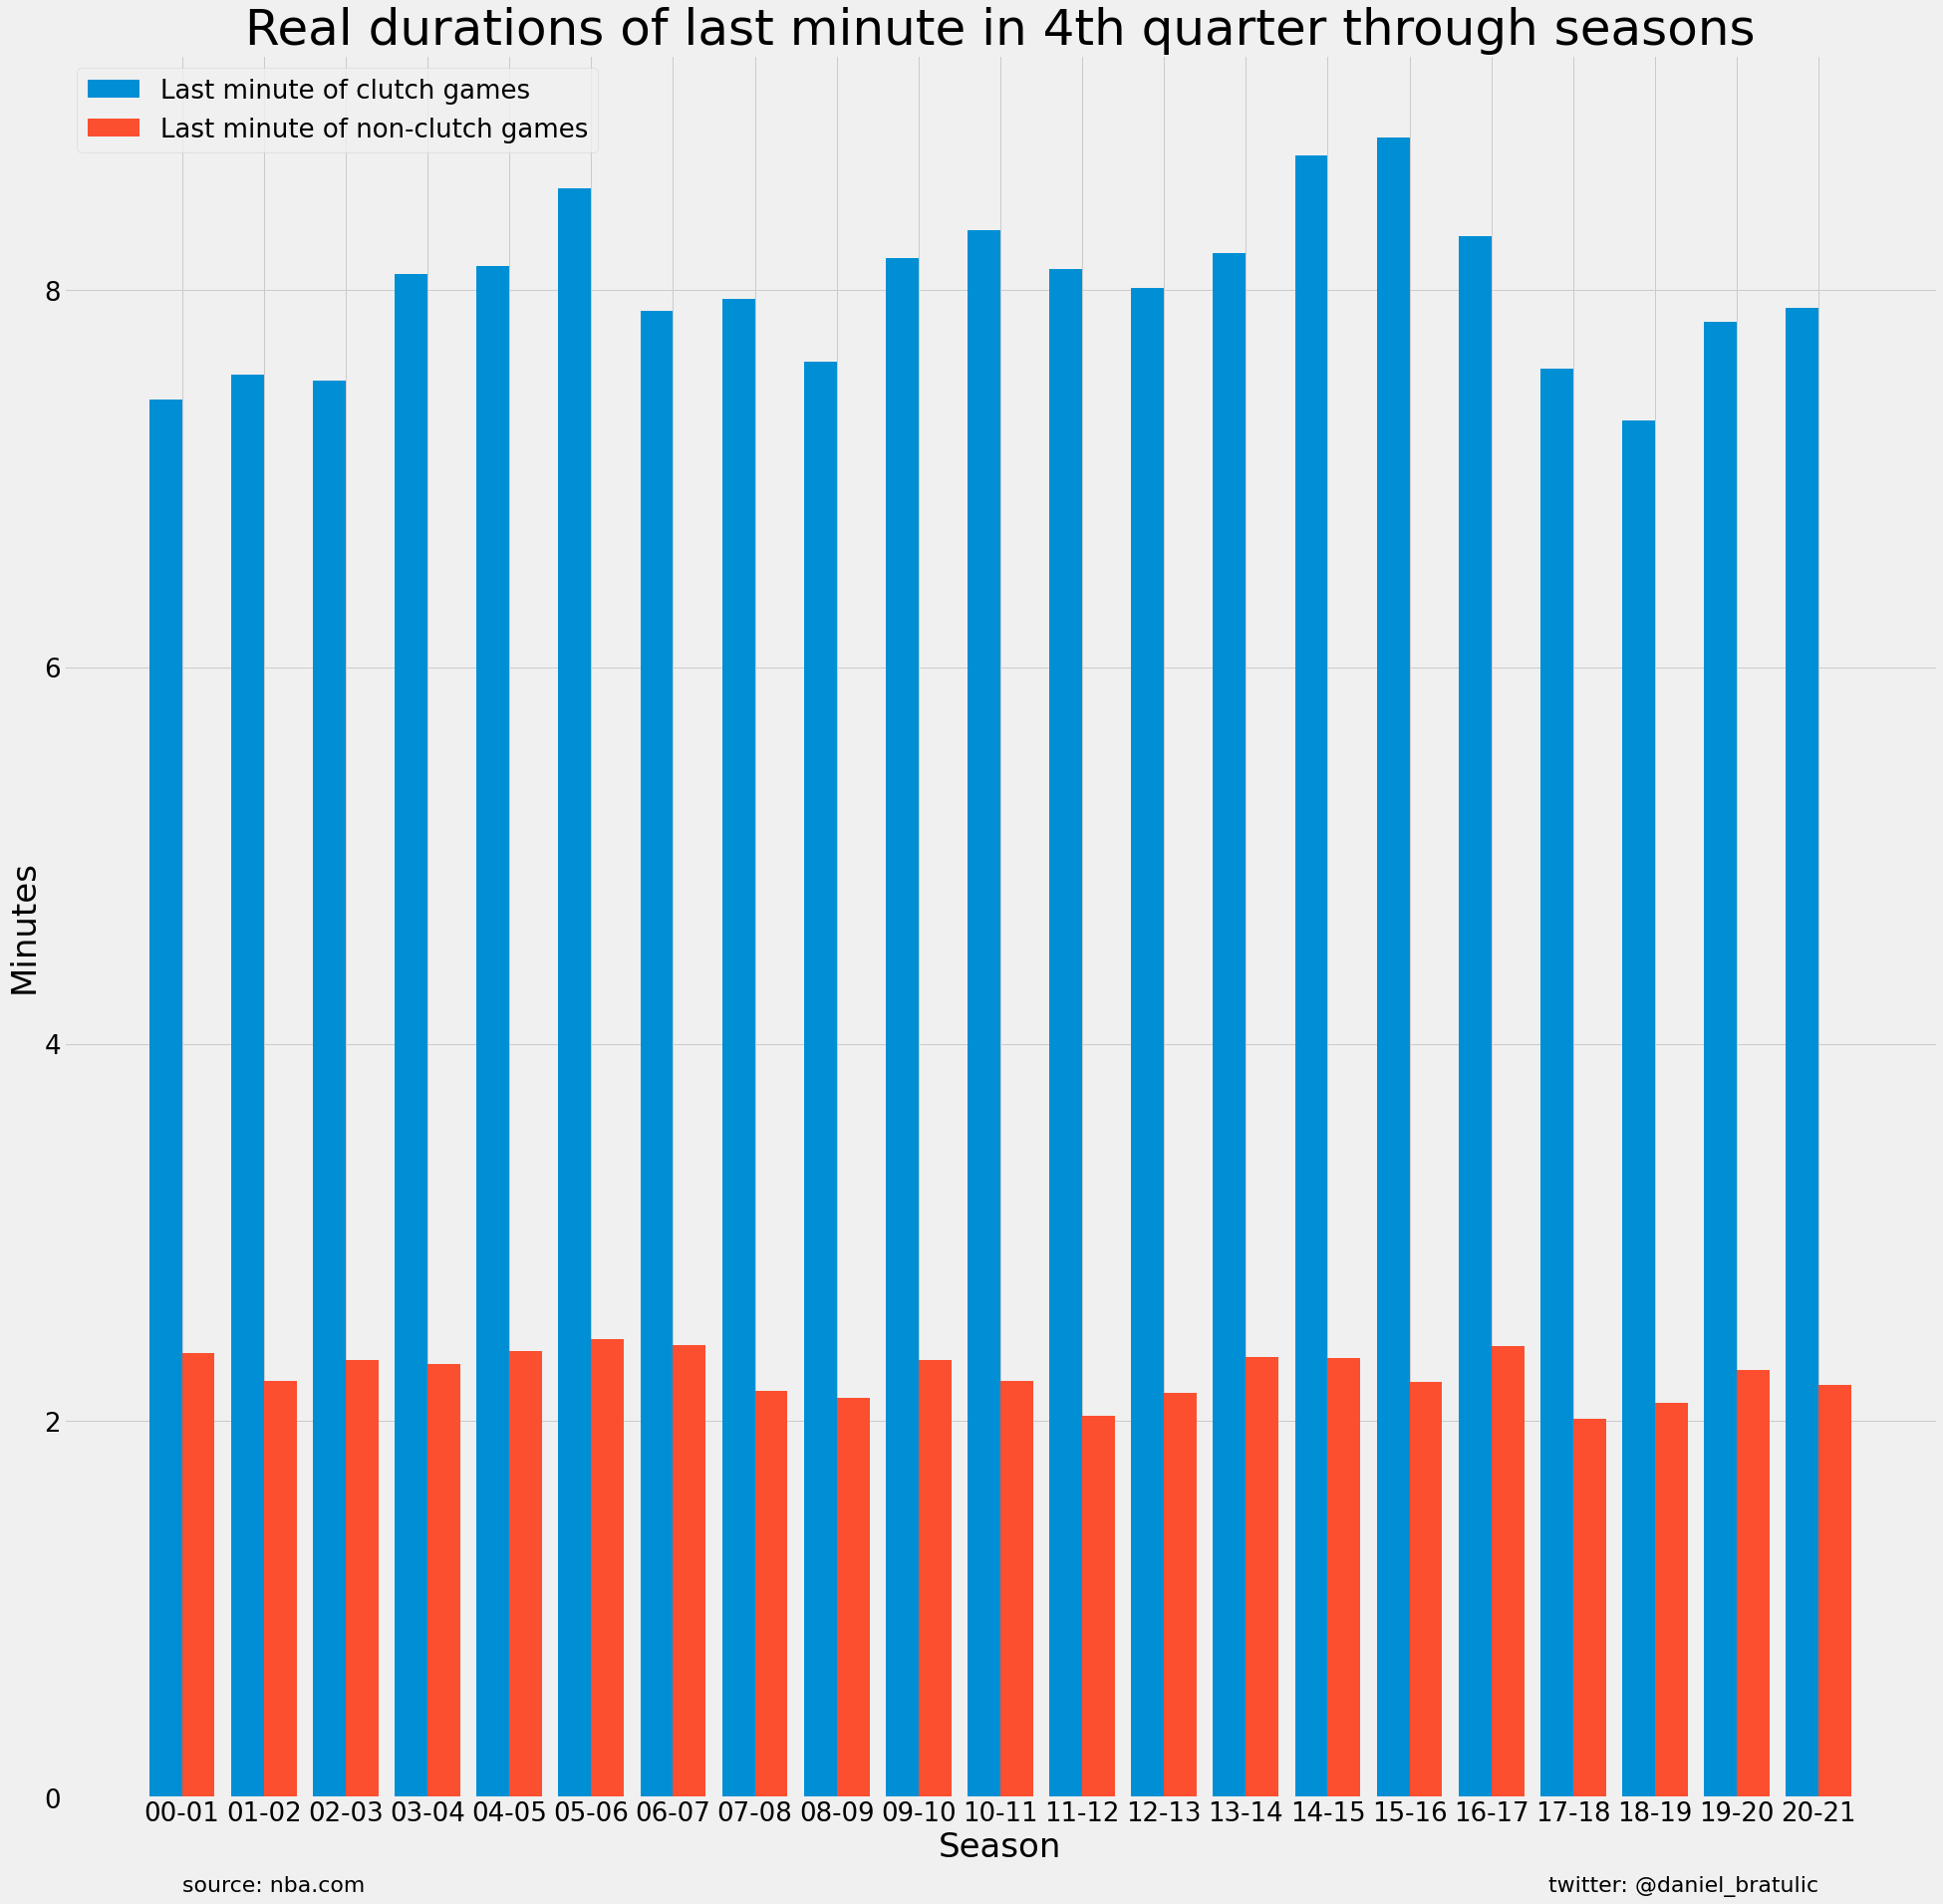

In [177]:
fig, ax = plt.subplots(figsize=(30, 30))

size=38
#ax.plot(seasons, clutch_durations, label='Last minute of clutch games')
#ax.plot(seasons, non_clutch_durations, label='Last minute of non-clutch games')
ax.bar(x=[item-0.4 for item in range(len(seasons))], height=clutch_durations, width=0.4, label='Last minute of clutch games', align='edge')
ax.bar(x=[item for item in range(len(seasons))], height=non_clutch_durations, width=0.4, label='Last minute of non-clutch games', align='edge')
ax.set_xticks([item for item in range(len(seasons))])
ax.set_xticklabels([item[2:] for item in seasons])
ax.set_title("Real durations of last minute in 4th quarter through seasons", size=size+12)
ax.set_xlabel("Season", size=size-4)
ax.set_ylabel("Minutes", size=size-4)

ax.legend(fontsize=size-12)
ax.tick_params(labelsize=size-12)
ax.text(x=len(seasons)-1, y=-0.5, s='twitter: @daniel_bratulic', ha='right', size=22)
ax.text(x=0, y=-0.5, s='source: nba.com', ha='left', size=22)

In [17]:
"""
Season: 2000-01; Average duration of last minute in clutch games: 7.417153996101365
Season: 2000-01; Average duration of last minute in non-clutch games: 2.3593984962406016
Total time: 85.6796863079071, season: 2000-01
Season: 2001-02; Average duration of last minute in clutch games: 7.550537634408602
Season: 2001-02; Average duration of last minute in non-clutch games: 2.2113821138211383
Total time: 69.63187456130981, season: 2001-02
Season: 2002-03; Average duration of last minute in clutch games: 7.517906336088155
Season: 2002-03; Average duration of last minute in non-clutch games: 2.32064128256513
Total time: 46.55984425544739, season: 2002-03
Season: 2003-04; Average duration of last minute in clutch games: 8.087606837606838
Season: 2003-04; Average duration of last minute in non-clutch games: 2.3026315789473686
Total time: 69.369544506073, season: 2003-04
Season: 2004-05; Average duration of last minute in clutch games: 8.12742980561555
Season: 2004-05; Average duration of last minute in non-clutch games: 2.3727422003284073
Total time: 70.57036852836609, season: 2004-05
Season: 2005-06; Average duration of last minute in clutch games: 8.541247484909457
Season: 2005-06; Average duration of last minute in non-clutch games: 2.4335443037974684
Total time: 196.17408418655396, season: 2005-06
Season: 2006-07; Average duration of last minute in clutch games: 7.8879668049792535
Season: 2006-07; Average duration of last minute in non-clutch games: 2.4012738853503186
Total time: 192.49303579330444, season: 2006-07
Season: 2007-08; Average duration of last minute in clutch games: 7.954441913439635
Season: 2007-08; Average duration of last minute in non-clutch games: 2.160968660968661
Total time: 199.84662055969238, season: 2007-08
Season: 2008-09; Average duration of last minute in clutch games: 7.622601279317697
Season: 2008-09; Average duration of last minute in non-clutch games: 2.120795107033639
Total time: 192.49111247062683, season: 2008-09
Season: 2009-10; Average duration of last minute in clutch games: 8.16891891891892
Season: 2009-10; Average duration of last minute in non-clutch games: 2.3206997084548107
Total time: 195.73390555381775, season: 2009-10
Season: 2010-11; Average duration of last minute in clutch games: 8.317718940936864
Season: 2010-11; Average duration of last minute in non-clutch games: 2.2095238095238097
Total time: 199.92997932434082, season: 2010-11
Season: 2011-12; Average duration of last minute in clutch games: 8.110824742268042
Season: 2011-12; Average duration of last minute in non-clutch games: 2.0279850746268657
Total time: 149.41084027290344, season: 2011-12
Season: 2012-13; Average duration of last minute in clutch games: 8.009541984732824
Season: 2012-13; Average duration of last minute in non-clutch games: 2.1460992907801417
Total time: 219.5752501487732, season: 2012-13
Season: 2013-14; Average duration of last minute in clutch games: 8.196153846153846
Season: 2013-14; Average duration of last minute in non-clutch games: 2.33943661971831
Total time: 223.85443902015686, season: 2013-14
"""

'\nSeason: 2000-01; Average duration of last minute in clutch games: 7.417153996101365\nSeason: 2000-01; Average duration of last minute in non-clutch games: 2.3593984962406016\nTotal time: 85.6796863079071, season: 2000-01\nSeason: 2001-02; Average duration of last minute in clutch games: 7.550537634408602\nSeason: 2001-02; Average duration of last minute in non-clutch games: 2.2113821138211383\nTotal time: 69.63187456130981, season: 2001-02\nSeason: 2002-03; Average duration of last minute in clutch games: 7.517906336088155\nSeason: 2002-03; Average duration of last minute in non-clutch games: 2.32064128256513\nTotal time: 46.55984425544739, season: 2002-03\nSeason: 2003-04; Average duration of last minute in clutch games: 8.087606837606838\nSeason: 2003-04; Average duration of last minute in non-clutch games: 2.3026315789473686\nTotal time: 69.369544506073, season: 2003-04\nSeason: 2004-05; Average duration of last minute in clutch games: 8.12742980561555\nSeason: 2004-05; Average d

#### Inspection

In [4]:
formatted_full = pd.read_csv(f'pbp_analysis/time_formatted_copy/2020-21.csv')

formatted_full = formatted_full.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
#formatted_full.loc[:, "PCTIMESECONDS"] = [720 - (int(item.PCTIMESTRING.split(":")[0]) * 60 + int(item.PCTIMESTRING.split(":")[1])) if item.PERIOD < 5 else 300 - (int(item.PCTIMESTRING.split(":")[0]) * 60 + int(item.PCTIMESTRING.split(":")[1])) for index, item in formatted_full.iterrows()]

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [111]:
formatted_full.loc[:, 'GAME_ID'] = [f"00{item}" for item in formatted_full.GAME_ID.astype(str)]

In [189]:
clutch_games = formatted_full.loc[(formatted_full.PERIOD >= 4) & (formatted_full.ADJ_MARGIN.abs() <= 5) & (formatted_full.PCTIMESECONDS >= 660)]

In [190]:
clutch_ids = clutch_games.GAME_ID.unique()
other_ids = formatted_full.loc[~formatted_full.GAME_ID.isin(clutch_ids)].GAME_ID.unique()

In [191]:
formatted_full.DATE_TIME = formatted_full.DATE_TIME.astype('datetime64')

In [192]:
len(clutch_ids)

278

In [193]:
len(other_ids)

412

In [196]:
278 + 412

690

In [197]:
278/690

0.4028985507246377

In [121]:
clutch_lengths = []
target_time = 660
period = 4
max_min = 0
for game_id in other_ids:
    if game_id == '0021700211':
        continue
    target_df = formatted_full.loc[formatted_full.GAME_ID == game_id]
    target_df = target_df.loc[target_df.EVENTMSGTYPE != 13]
    first = target_df.loc[(target_df.PERIOD == period) & (target_df.PCTIMESECONDS >= target_time)].iloc[0]
    last = target_df.loc[(target_df.PERIOD == period) & (target_df.PCTIMESECONDS >= target_time)].iloc[-1]
    #print(game_id)
    #print((last.DATE_TIME - first.DATE_TIME).total_seconds())
    #print(f"\t{first.DATE_TIME}")
    #print(f"\t{last.DATE_TIME}")
    diff = (last.DATE_TIME - first.DATE_TIME)
    total_min = diff.total_seconds() / 60
    if diff.total_seconds() < 0:
        continue
    if total_min > max_min:
        max_id = game_id
        max_min = total_min
    clutch_lengths.append(diff.total_seconds() / 60)

In [46]:
formatted_full

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESECONDS,PCTIMESTRING,PERIOD,...,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VIDEO_AVAILABLE_FLAG,VISITORDESCRIPTION,WCTIMESTRING,DATE_TIME,ADJ_SCORE,ADJ_MARGIN
0,313244,0,12,2,0022000712,,Start of 1st Period (8:11 PM EST),0,12:00,1,...,NaN,NaN,NaN,NaN,0,,8:11 PM,2021-03-29 20:11:00,0 - 0,0
1,313245,0,10,4,0022000712,Jump Ball Olynyk vs. Valanciunas: Tip to Allen,,0,12:00,1,...,1.610613e+09,Grizzlies,NaN,NaN,1,,8:11 PM,2021-03-29 20:11:00,0 - 0,0
2,313246,2,6,7,0022000712,Wall S.FOUL (P1.T1) (K.Fitzgerald),,16,11:44,1,...,NaN,NaN,NaN,NaN,1,,8:11 PM,2021-03-29 20:11:00,0 - 0,0
3,313247,11,3,9,0022000712,,,16,11:44,1,...,NaN,NaN,NaN,NaN,1,MISS Valanciunas Free Throw 1 of 2,8:11 PM,2021-03-29 20:11:00,0 - 0,0
4,313248,1,4,10,0022000712,,,16,11:44,1,...,NaN,NaN,NaN,NaN,0,Grizzlies Rebound,8:11 PM,2021-03-29 20:11:00,0 - 0,0
5,313249,12,3,11,0022000712,,,16,11:44,1,...,NaN,NaN,1 - 0,-1,1,Valanciunas Free Throw 2 of 2 (1 PTS),8:12 PM,2021-03-29 20:12:00,1 - 0,-1
6,313250,57,1,12,0022000712,Tate 5' Driving Hook Shot (2 PTS),,38,11:22,1,...,NaN,NaN,1 - 2,1,1,,8:12 PM,2021-03-29 20:12:00,1 - 2,1
7,313251,86,2,13,0022000712,,,63,10:57,1,...,NaN,NaN,NaN,NaN,1,MISS Valanciunas 9' Turnaround Fadeaway Shot,8:13 PM,2021-03-29 20:13:00,1 - 2,1
8,313252,0,4,14,0022000712,Porter Jr. REBOUND (Off:0 Def:1),,64,10:56,1,...,NaN,NaN,NaN,NaN,1,,8:13 PM,2021-03-29 20:13:00,1 - 2,1
9,313253,43,1,15,0022000712,Olynyk 2' Alley Oop Layup (2 PTS) (Porter Jr. ...,,83,10:37,1,...,NaN,NaN,1 - 4,3,1,,8:13 PM,2021-03-29 20:13:00,1 - 4,3


In [120]:
np.mean(clutch_lengths)

7.894160583941606

In [122]:
np.mean(clutch_lengths)

2.201492537313433

## Length of replays

In [47]:
replays = formatted_full.loc[formatted_full.EVENTMSGTYPE == 18]

In [60]:
other_replays = replays.loc[replays.PERIOD < 4]

In [61]:
game_id_eventnum = other_replays.loc[:, ['GAME_ID', 'EVENTNUM']]

In [62]:
indices = game_id_eventnum.index.tolist()

In [63]:
prev_indices = [index - 1 for index in indices]

In [64]:
prev_replay = formatted_full.loc[prev_indices]

In [65]:
avg_diffs = []
for i in range(len(other_replays)):
    item = other_replays.iloc[i]
    prev_item = prev_replay.iloc[i]
    diff = (item.DATE_TIME - prev_item.DATE_TIME).total_seconds() / 60
    
    avg_diffs.append(diff)

In [66]:
np.mean(avg_diffs)

0.4220055710306407

In [56]:
fourth_ot_replays = replays.loc[replays.PERIOD >= 4]

In [57]:
prev_fourth_indices = [index - 1 for index in fourth_ot_replays.index.tolist()]
prev_fourth_replay = formatted_full.loc[prev_fourth_indices]

In [58]:
avg_diffs = []
for i in range(len(fourth_ot_replays)):
    item = fourth_ot_replays.iloc[i]
    prev_item = prev_fourth_replay.iloc[i]
    diff = (item.DATE_TIME - prev_item.DATE_TIME).total_seconds() / 60
    
    avg_diffs.append(diff)

In [59]:
np.mean(avg_diffs)

0.4661508704061896

## Timeouts

In [69]:
timeouts = formatted_full.loc[formatted_full.EVENTMSGTYPE == 9]

In [73]:
timeouts.PCTIMESECONDS // 60

48         5
79         8
100        9
156        5
212        9
          ..
639145    11
639167     1
639201     4
639219     7
639261    11
Name: PCTIMESECONDS, Length: 15196, dtype: int64

In [74]:
timeouts = timeouts.loc[:, ['PERIOD', 'PCTIMESECONDS']]

In [75]:
timeouts.loc[:, 'MINUTES'] = timeouts.PCTIMESECONDS // 60

In [80]:
len(timeouts.loc[(timeouts.PERIOD == 4) & (timeouts.MINUTES == 11)])

1390

In [82]:
counts = timeouts.groupby(('PERIOD', 'MINUTES')).size().reset_index()

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


In [87]:
counts = counts.loc[counts.MINUTES != 12]

In [134]:
non_twelve = timeouts.loc[timeouts.MINUTES != 12]

In [135]:
non_twelve = non_twelve.loc[:, ['PERIOD', 'MINUTES']]

In [136]:
df_test = non_twelve.groupby(('PERIOD', 'MINUTES')).size().unstack()

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


In [137]:
df_test.fillna(0.0)

MINUTES,0,1,2,3,4,5,6,7,8,9,10,11
PERIOD,,,,,,,,,,,,
1,12.0,36.0,108.0,226.0,332.0,634.0,214.0,286.0,358.0,586.0,120.0,28.0
2,18.0,152.0,300.0,352.0,354.0,474.0,310.0,290.0,320.0,428.0,88.0,30.0
3,48.0,134.0,282.0,348.0,326.0,484.0,276.0,292.0,346.0,472.0,140.0,84.0
4,38.0,218.0,348.0,408.0,454.0,496.0,390.0,526.0,768.0,308.0,342.0,1390.0
5,4.0,12.0,16.0,30.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,2.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, -0.75, 'source: nba.com')

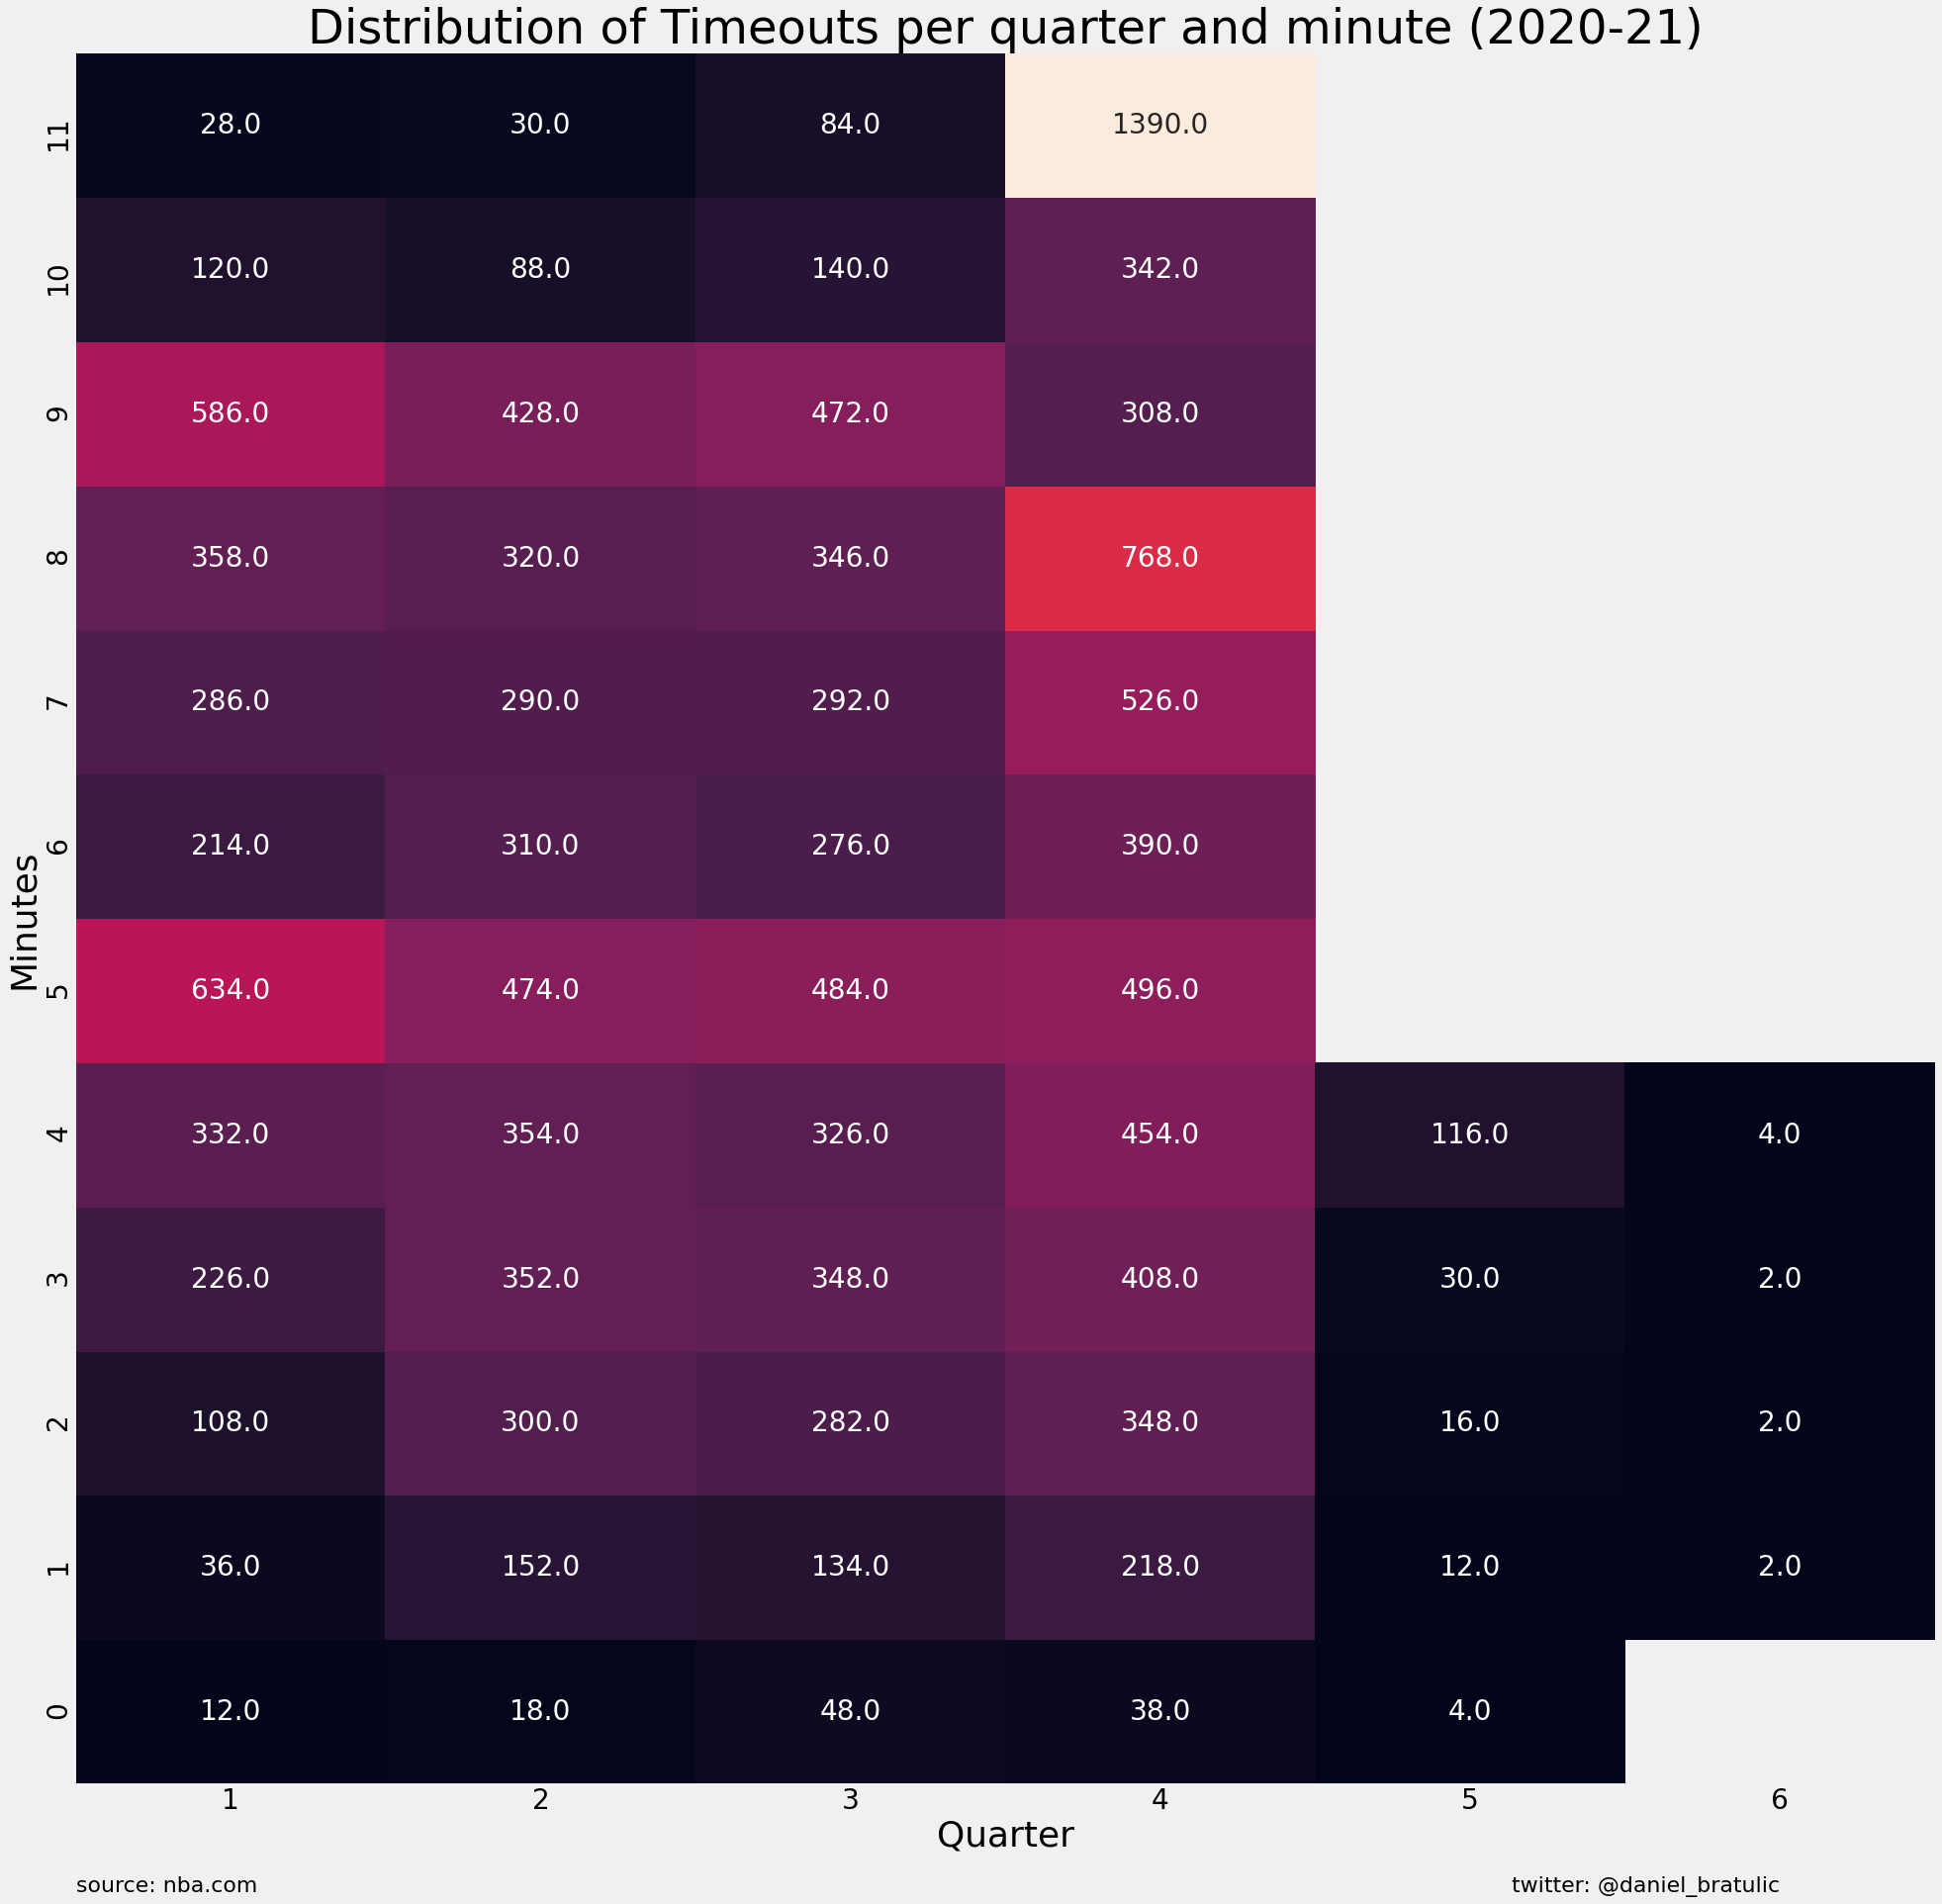

In [183]:
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(df_test.T, annot=True, cbar=False, fmt='', annot_kws={'size': 28})
ax.tick_params(labelsize=28)
ax.set_ylabel("Minutes", size=36)
ax.set_xlabel("Quarter", size=36)
ax.set_title("Distribution of Timeouts per quarter and minute (2020-21)", size=48)
ax.invert_yaxis()
#ax.set_yticklabels([item for item in range(1, 13, 1)])
ax.text(x=5.5, y=-0.75, s='twitter: @daniel_bratulic', ha='right', size=22)
ax.text(x=0, y=-0.75, s='source: nba.com', ha='left', size=22)

In [148]:
len(timeouts.loc[(timeouts.PERIOD == 4) & (timeouts.MINUTES == 11)]) / len(non_twelve)

0.09167655982060414

## Timeouts through seasons

In [152]:
share_of_last_min_timeouts = []
for season in seasons:
    pbp_df = pd.read_csv(f'pbp_analysis/time_formatted_copy/{season}.csv')
    timeouts = pbp_df.loc[pbp_df.EVENTMSGTYPE == 9]
    timeouts.loc[:, 'MINUTES'] = timeouts.PCTIMESECONDS // 60
    timeouts = timeouts.loc[(timeouts.MINUTES != 12) & (timeouts.PERIOD < 5)]
    share_of_last_min_timeouts.append(
        len(timeouts.loc[(timeouts.PERIOD == 4) & (timeouts.MINUTES == 11)]) / len(timeouts) * 100
    )

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Speci

In [153]:
share_of_last_min_timeouts

[8.333333333333332,
 8.162399207808742,
 8.435337945715807,
 9.089002307208279,
 9.158932297287576,
 9.581201185025586,
 9.783573428005734,
 8.830401319406267,
 9.446479165227007,
 9.380420453757026,
 10.268225584594223,
 9.657477025898078,
 9.4913112164297,
 9.656493265785246,
 9.836370397917442,
 9.829668628058222,
 9.329588472340946,
 9.050433714592769,
 8.469055374592834,
 9.128240225853366,
 9.282756778415921]

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


Text(0, 7.9123992078087415, 'source: nba.com')

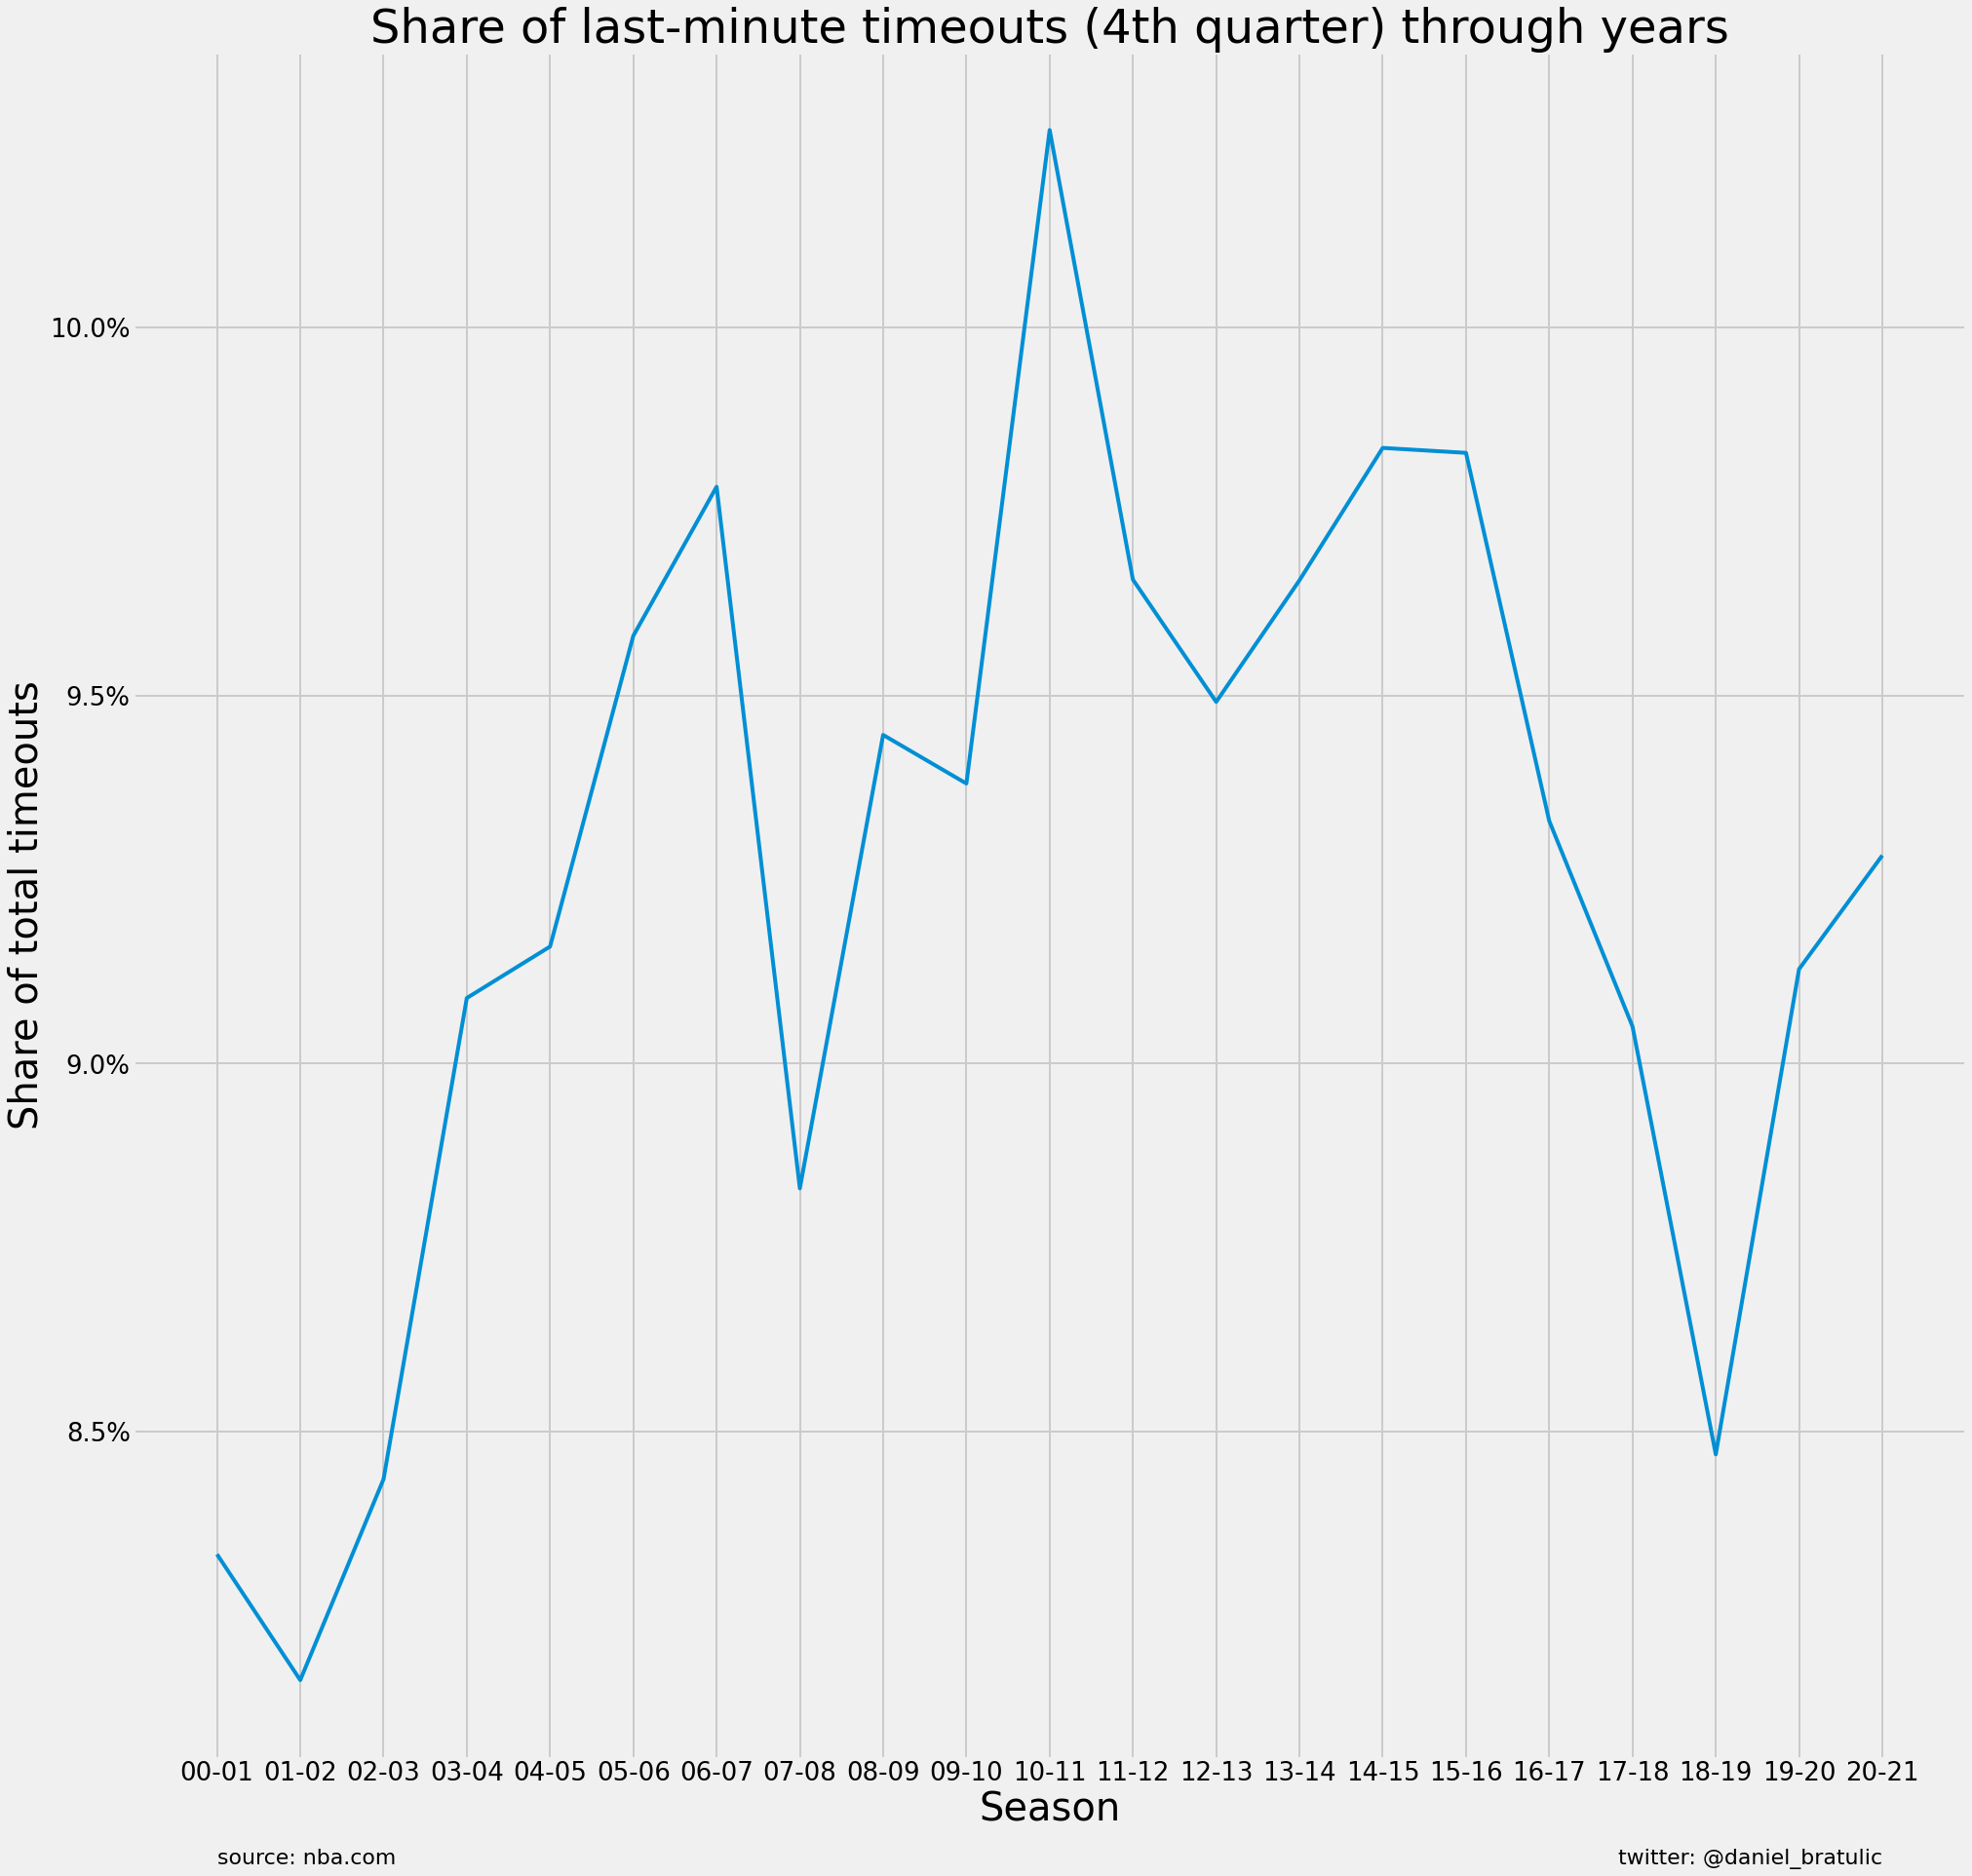

In [184]:
fig, ax = plt.subplots(figsize=(30, 30))

size = 32
ax.plot(seasons, share_of_last_min_timeouts)
ax.set_xlabel("Season", size=size+8)
ax.set_ylabel("Share of total timeouts", size=size+8)
ax.set_title("Share of last-minute timeouts (4th quarter) through years", size=size+16)
ax.tick_params(labelsize=size-6)
ax.grid(True, alpha=1.0, lw=2)
ax.set_xticklabels([item[2:] for item in seasons])
ax.set_yticklabels([f"{item}%" for item in ax.get_yticks()])
ax.text(x=len(seasons)-1, y=np.min(share_of_last_min_timeouts)-0.25, s='twitter: @daniel_bratulic', ha='right', size=22)
ax.text(x=0, y=np.min(share_of_last_min_timeouts)-0.25, s='source: nba.com', ha='left', size=22)

### Number of timeouts in clutch games

In [198]:
clutch_games

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESECONDS,PCTIMESTRING,PERIOD,...,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VIDEO_AVAILABLE_FLAG,VISITORDESCRIPTION,WCTIMESTRING,DATE_TIME,ADJ_SCORE,ADJ_MARGIN
1925,314671,2,5,677,0022000709,Brown Lost Ball Turnover (P1.T16),,660,1:00,4,...,NaN,NaN,NaN,NaN,1,Edwards STEAL (3 STL),9:45 PM,2021-03-29 21:45:00,105 - 108,3
1926,314672,41,1,679,0022000709,,,662,0:58,4,...,NaN,NaN,107 - 108,1,1,Edwards Running Layup (23 PTS),9:45 PM,2021-03-29 21:45:00,107 - 108,1
1927,314673,2,6,680,0022000709,Brown S.FOUL (P5.T2) (N.Buchert),,662,0:58,4,...,NaN,NaN,NaN,NaN,1,,9:45 PM,2021-03-29 21:45:00,107 - 108,1
1928,314674,10,3,682,0022000709,,,662,0:58,4,...,NaN,NaN,NaN,NaN,1,MISS Edwards Free Throw 1 of 1,9:45 PM,2021-03-29 21:45:00,107 - 108,1
1929,314675,0,4,683,0022000709,Harden REBOUND (Off:0 Def:11),,664,0:56,4,...,NaN,NaN,NaN,NaN,1,,9:45 PM,2021-03-29 21:45:00,107 - 108,1
1930,314676,80,2,684,0022000709,MISS Irving 25' 3PT Step Back Jump Shot,,679,0:41,4,...,NaN,NaN,NaN,NaN,1,,9:45 PM,2021-03-29 21:45:00,107 - 108,1
1931,314677,0,4,685,0022000709,,,684,0:36,4,...,NaN,NaN,NaN,NaN,1,Edwards REBOUND (Off:3 Def:7),9:46 PM,2021-03-29 21:46:00,107 - 108,1
1932,314678,1,9,686,0022000709,,,684,0:36,4,...,NaN,NaN,NaN,NaN,0,Timberwolves Timeout: Regular (Reg.6 Short 0),9:46 PM,2021-03-29 21:46:00,107 - 108,1
1933,314679,101,2,687,0022000709,,,700,0:20,4,...,NaN,NaN,NaN,NaN,1,MISS Edwards 9' Driving Floating Jump Shot,9:48 PM,2021-03-29 21:48:00,107 - 108,1
1934,314680,0,4,688,0022000709,Brown REBOUND (Off:2 Def:3),,704,0:16,4,...,NaN,NaN,NaN,NaN,1,,9:48 PM,2021-03-29 21:48:00,107 - 108,1


In [201]:
len(clutch_games.GAME_ID.unique())

278

In [203]:
clutch_games.PCTIMESTRING.unique()

array(['1:00', '0:58', '0:56', '0:41', '0:36', '0:20', '0:16', '0:14',
       '0:10', '0:08', '0:03', '0:00', '0:50', '0:33', '0:25', '0:24',
       '0:17', '0:57', '0:39', '0:30', '0:12', '0:09', '0:07', '0:05',
       '0:01', '0:35', '0:31', '0:26', '0:22', '0:15', '0:06', '0:04',
       '0:37', '0:13', '0:02', '0:53', '0:45', '0:23', '0:21', '0:11',
       '0:49', '0:28', '0:27', '0:44', '0:42', '0:38', '0:34', '0:18',
       '0:59', '0:47', '0:52', '0:19', '0:40', '0:32', '0:55', '0:51',
       '0:54', '0:29', '0:48', '0:43', '0:46'], dtype=object)

In [200]:
timeouts = clutch_games.loc[pbp_df.EVENTMSGTYPE == 9]
timeouts.loc[:, 'MINUTES'] = timeouts.PCTIMESECONDS // 60
timeouts = timeouts.loc[(timeouts.MINUTES != 12) & (timeouts.PERIOD < 5)]
print(len(timeouts.loc[(timeouts.PERIOD == 4) & (timeouts.MINUTES == 11)]))

988


In [207]:
timeouts

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESECONDS,PCTIMESTRING,PERIOD,...,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VIDEO_AVAILABLE_FLAG,VISITORDESCRIPTION,WCTIMESTRING,DATE_TIME,ADJ_SCORE,ADJ_MARGIN,MINUTES
1932,314678,1,9,686,0022000709,,,684,0:36,4,...,NaN,NaN,NaN,0,Timberwolves Timeout: Regular (Reg.6 Short 0),9:46 PM,2021-03-29 21:46:00,107 - 108,1,11
1941,314687,1,9,699,0022000709,,,706,0:14,4,...,NaN,NaN,NaN,0,Timberwolves Timeout: Regular (Reg.7 Short 0),9:49 PM,2021-03-29 21:49:00,107 - 110,3,11
5481,317336,1,9,650,0022000708,,,670,0:50,4,...,NaN,NaN,NaN,0,Pelicans Timeout: Regular (Reg.4 Short 0),9:57 PM,2021-03-29 21:57:00,110 - 107,-3,11
5484,317339,1,9,655,0022000708,CELTICS Timeout: Regular (Full 6 Short 0),,687,0:33,4,...,NaN,NaN,NaN,0,,9:59 PM,2021-03-29 21:59:00,112 - 107,-5,11
6850,314678,1,9,686,0022000709,,,684,0:36,4,...,NaN,NaN,NaN,0,Timberwolves Timeout: Regular (Reg.6 Short 0),9:46 PM,2021-03-29 21:46:00,107 - 108,1,11
6859,314687,1,9,699,0022000709,,,706,0:14,4,...,NaN,NaN,NaN,0,Timberwolves Timeout: Regular (Reg.7 Short 0),9:49 PM,2021-03-29 21:49:00,107 - 110,3,11
9601,317336,1,9,650,0022000708,,,670,0:50,4,...,NaN,NaN,NaN,0,Pelicans Timeout: Regular (Reg.4 Short 0),9:57 PM,2021-03-29 21:57:00,110 - 107,-3,11
9604,317339,1,9,655,0022000708,CELTICS Timeout: Regular (Full 6 Short 0),,687,0:33,4,...,NaN,NaN,NaN,0,,9:59 PM,2021-03-29 21:59:00,112 - 107,-5,11
10920,319639,1,9,633,0022000706,LAKERS Timeout: Regular (Full 7 Short 0),,690,0:30,4,...,NaN,NaN,NaN,0,,12:18 AM,2021-03-29 00:18:00,93 - 96,3,11
10925,319644,1,9,639,0022000706,,,715,0:05,4,...,NaN,NaN,NaN,0,Magic Timeout: Regular (Reg.6 Short 0),12:20 AM,2021-03-29 00:20:00,93 - 96,3,11


In [204]:
988/1390

0.7107913669064748

In [205]:
278*4

1112

In [206]:
988/278

3.553956834532374

In [219]:
clutch_games

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESECONDS,PCTIMESTRING,PERIOD,...,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VIDEO_AVAILABLE_FLAG,VISITORDESCRIPTION,WCTIMESTRING,DATE_TIME,ADJ_SCORE,ADJ_MARGIN
1925,314671,2,5,677,0022000709,Brown Lost Ball Turnover (P1.T16),,660,1:00,4,...,NaN,NaN,NaN,NaN,1,Edwards STEAL (3 STL),9:45 PM,2021-03-29 21:45:00,105 - 108,3
1926,314672,41,1,679,0022000709,,,662,0:58,4,...,NaN,NaN,107 - 108,1,1,Edwards Running Layup (23 PTS),9:45 PM,2021-03-29 21:45:00,107 - 108,1
1927,314673,2,6,680,0022000709,Brown S.FOUL (P5.T2) (N.Buchert),,662,0:58,4,...,NaN,NaN,NaN,NaN,1,,9:45 PM,2021-03-29 21:45:00,107 - 108,1
1928,314674,10,3,682,0022000709,,,662,0:58,4,...,NaN,NaN,NaN,NaN,1,MISS Edwards Free Throw 1 of 1,9:45 PM,2021-03-29 21:45:00,107 - 108,1
1929,314675,0,4,683,0022000709,Harden REBOUND (Off:0 Def:11),,664,0:56,4,...,NaN,NaN,NaN,NaN,1,,9:45 PM,2021-03-29 21:45:00,107 - 108,1
1930,314676,80,2,684,0022000709,MISS Irving 25' 3PT Step Back Jump Shot,,679,0:41,4,...,NaN,NaN,NaN,NaN,1,,9:45 PM,2021-03-29 21:45:00,107 - 108,1
1931,314677,0,4,685,0022000709,,,684,0:36,4,...,NaN,NaN,NaN,NaN,1,Edwards REBOUND (Off:3 Def:7),9:46 PM,2021-03-29 21:46:00,107 - 108,1
1932,314678,1,9,686,0022000709,,,684,0:36,4,...,NaN,NaN,NaN,NaN,0,Timberwolves Timeout: Regular (Reg.6 Short 0),9:46 PM,2021-03-29 21:46:00,107 - 108,1
1933,314679,101,2,687,0022000709,,,700,0:20,4,...,NaN,NaN,NaN,NaN,1,MISS Edwards 9' Driving Floating Jump Shot,9:48 PM,2021-03-29 21:48:00,107 - 108,1
1934,314680,0,4,688,0022000709,Brown REBOUND (Off:2 Def:3),,704,0:16,4,...,NaN,NaN,NaN,NaN,1,,9:48 PM,2021-03-29 21:48:00,107 - 108,1


In [245]:
prev_fourth_indices = [index + 1 for index in timeouts.index.tolist()]
prev_fourth_replay = clutch_games.loc[prev_fourth_indices]

avg_diffs = []
for i in range(len(timeouts)):
    item = timeouts.iloc[i]
    prev_item = prev_fourth_replay.iloc[i]
    diff = (prev_item.DATE_TIME - item.DATE_TIME).total_seconds() / 60
    if np.isnan(diff):
        continue
    if (diff < 0):
        print(i)
        continue
    avg_diffs.append(diff)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


745
748


In [246]:
np.mean(avg_diffs)

1.1341463414634145

In [247]:
0.13 * 60

7.800000000000001

### Timeout type

In [5]:
formatted_full

,Unnamed: 0,Unnamed: 0.1,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESECONDS,PCTIMESTRING,...,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VIDEO_AVAILABLE_FLAG,VISITORDESCRIPTION,WCTIMESTRING,DATE_TIME,ADJ_SCORE,ADJ_MARGIN
0,0,313244,0,12,2,22000712,,Start of 1st Period (8:11 PM EST),0,12:00,...,NaN,NaN,NaN,NaN,0,,8:11 PM,2021-03-29 20:11:00,0 - 0,0
1,1,313245,0,10,4,22000712,Jump Ball Olynyk vs. Valanciunas: Tip to Allen,,0,12:00,...,1.610613e+09,Grizzlies,NaN,NaN,1,,8:11 PM,2021-03-29 20:11:00,0 - 0,0
2,2,313246,2,6,7,22000712,Wall S.FOUL (P1.T1) (K.Fitzgerald),,16,11:44,...,NaN,NaN,NaN,NaN,1,,8:11 PM,2021-03-29 20:11:00,0 - 0,0
3,3,313247,11,3,9,22000712,,,16,11:44,...,NaN,NaN,NaN,NaN,1,MISS Valanciunas Free Throw 1 of 2,8:11 PM,2021-03-29 20:11:00,0 - 0,0
4,4,313248,1,4,10,22000712,,,16,11:44,...,NaN,NaN,NaN,NaN,0,Grizzlies Rebound,8:11 PM,2021-03-29 20:11:00,0 - 0,0
5,5,313249,12,3,11,22000712,,,16,11:44,...,NaN,NaN,1 - 0,-1,1,Valanciunas Free Throw 2 of 2 (1 PTS),8:12 PM,2021-03-29 20:12:00,1 - 0,-1
6,6,313250,57,1,12,22000712,Tate 5' Driving Hook Shot (2 PTS),,38,11:22,...,NaN,NaN,1 - 2,1,1,,8:12 PM,2021-03-29 20:12:00,1 - 2,1
7,7,313251,86,2,13,22000712,,,63,10:57,...,NaN,NaN,NaN,NaN,1,MISS Valanciunas 9' Turnaround Fadeaway Shot,8:13 PM,2021-03-29 20:13:00,1 - 2,1
8,8,313252,0,4,14,22000712,Porter Jr. REBOUND (Off:0 Def:1),,64,10:56,...,NaN,NaN,NaN,NaN,1,,8:13 PM,2021-03-29 20:13:00,1 - 2,1
9,9,313253,43,1,15,22000712,Olynyk 2' Alley Oop Layup (2 PTS) (Porter Jr. ...,,83,10:37,...,NaN,NaN,1 - 4,3,1,,8:13 PM,2021-03-29 20:13:00,1 - 4,3


In [6]:
timeouts = formatted_full.loc[formatted_full.EVENTMSGTYPE == 9]

In [18]:
formatted_full.loc[formatted_full.VISITORDESCRIPTION.str.contains('Timeout')].VISITORDESCRIPTION.unique().tolist()

['Grizzlies Timeout: Regular (Reg.1 Short 0)',
 'Grizzlies Timeout: Regular (Reg.2 Short 0)',
 'Grizzlies Timeout: Regular (Reg.3 Short 0)',
 'Grizzlies Timeout: Regular (Reg.4 Short 0)',
 'Grizzlies Timeout: Regular (Reg.5 Short 0)',
 'Grizzlies Timeout: Regular (Reg.6 Short 0)',
 'Pacers Timeout: Regular (Reg.1 Short 0)',
 'Pacers Timeout: Regular (Reg.2 Short 0)',
 'Pacers Timeout: Regular (Reg.3 Short 0)',
 'Pacers Timeout: Regular (Reg.4 Short 0)',
 'Pacers Timeout: Regular (Reg.5 Short 0)',
 'Pacers Timeout: Coach Challenge (Reg.5 Short 0)',
 'Pacers Timeout: Regular (Reg.6 Short 0)',
 'Timberwolves Timeout: Regular (Reg.1 Short 0)',
 'Timberwolves Timeout: Regular (Reg.2 Short 0)',
 'Timberwolves Timeout: Regular (Reg.3 Short 0)',
 'Timberwolves Timeout: Regular (Reg.4 Short 0)',
 'Timberwolves Timeout: Regular (Reg.5 Short 0)',
 'Timberwolves Timeout: Regular (Reg.6 Short 0)',
 'Timberwolves Timeout: Regular (Reg.7 Short 0)',
 'Heat Timeout: Regular (Reg.1 Short 0)',
 'Heat Tim

In [14]:
list(timeouts.HOMEDESCRIPTION.unique())

['ROCKETS Timeout: Regular (Full 1 Short 0)',
 '',
 'ROCKETS Timeout: Regular (Full 2 Short 0)',
 'ROCKETS Timeout: Regular (Full 3 Short 0)',
 'ROCKETS Timeout: Regular (Full 4 Short 0)',
 'ROCKETS Timeout: Regular (Full 5 Short 0)',
 'ROCKETS Timeout: Regular (Full 6 Short 0)',
 'WIZARDS Timeout: Regular (Full 1 Short 0)',
 'WIZARDS Timeout: Regular (Full 2 Short 0)',
 'WIZARDS Timeout: Regular (Full 3 Short 0)',
 'WIZARDS Timeout: Regular (Full 4 Short 0)',
 'WIZARDS Timeout: Regular (Full 5 Short 0)',
 'NETS Timeout: Regular (Full 1 Short 0)',
 'NETS Timeout: Regular (Full 2 Short 0)',
 'NETS Timeout: Regular (Full 3 Short 0)',
 'KNICKS Timeout: Regular (Full 1 Short 0)',
 'KNICKS Timeout: Regular (Full 2 Short 0)',
 'KNICKS Timeout: Regular (Full 3 Short 0)',
 'KNICKS Timeout: Regular (Full 4 Short 0)',
 'CLIPPERS Timeout: Regular (Full 1 Short 0)',
 'CLIPPERS Timeout: Regular (Full 2 Short 0)',
 'CLIPPERS Timeout: Regular (Full 3 Short 0)',
 'CLIPPERS Timeout: Regular (Full 4 Sho